Analyze Visium H&E data
=======================

This tutorial shows how to apply Squidpy for the analysis of Visium spatial transcriptomics data.

Import packages & data
----------------------

In [1]:
import scanpy as sc
import anndata as ad
import squidpy as sq

import numpy as np
import pandas as pd
import pathlib

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.0 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6
squidpy==1.2.0


In [2]:
# set path
path = pathlib.Path("/data/day3_spatial_transcriptomics")

First, let's visualize cluster annotation in spatial context
with :func:`scanpy.pl.spatial`.

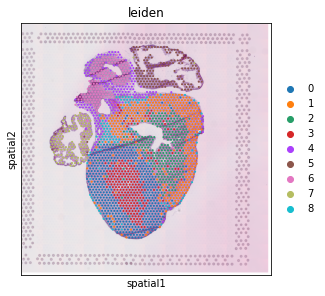

In [3]:
# load the pre-processed dataset
adata = sc.read(path / "V10F24-105_A1.h5ad")
sq.pl.spatial_scatter(adata, color="leiden")

Let's create an `ImageContainer` object from the high-resolution image.

In [4]:
img = sq.im.ImageContainer(
    adata.uns["spatial"]["V10F24-105_A1"]["images"]["hires"],
    scale=adata.uns["spatial"]["V10F24-105_A1"]["scalefactors"]["tissue_hires_scalef"],
)

Image features
--------------
Visium datasets contain high-resolution images of the tissue that was used for the gene extraction.
Using the function :func:`squidpy.im.calculate_image_features` you can calculate image features
for each Visium spot and create a ``obs x features`` matrix in ``adata`` that can then be analyzed together
with the ``obs x gene`` gene expression matrix.

By extracting image features we are aiming to get both similar and complementary information to the
gene expression values.
Similar information is for example present in the case of a tissue with two different cell types
whose morphology is different.
Such cell type information is then contained in both the gene expression values and the tissue image features.

In [5]:
# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f],
    axis="columns",
)
# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(
    adata.obsm["features"].columns
)

  0%|          | 0/2169 [00:00<?, ?/s]

  0%|          | 0/2169 [00:00<?, ?/s]

We can use the extracted image features to compute a new cluster annotation.
This could be useful to gain insights in similarities across spots based on image morphology.

/opt/conda/envs/day3_spatial_transcriptomics/lib/python3.8/site-packages/anndata/utils.py:143: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/tmp/ipykernel_46269/2374559455.py:12: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(features)


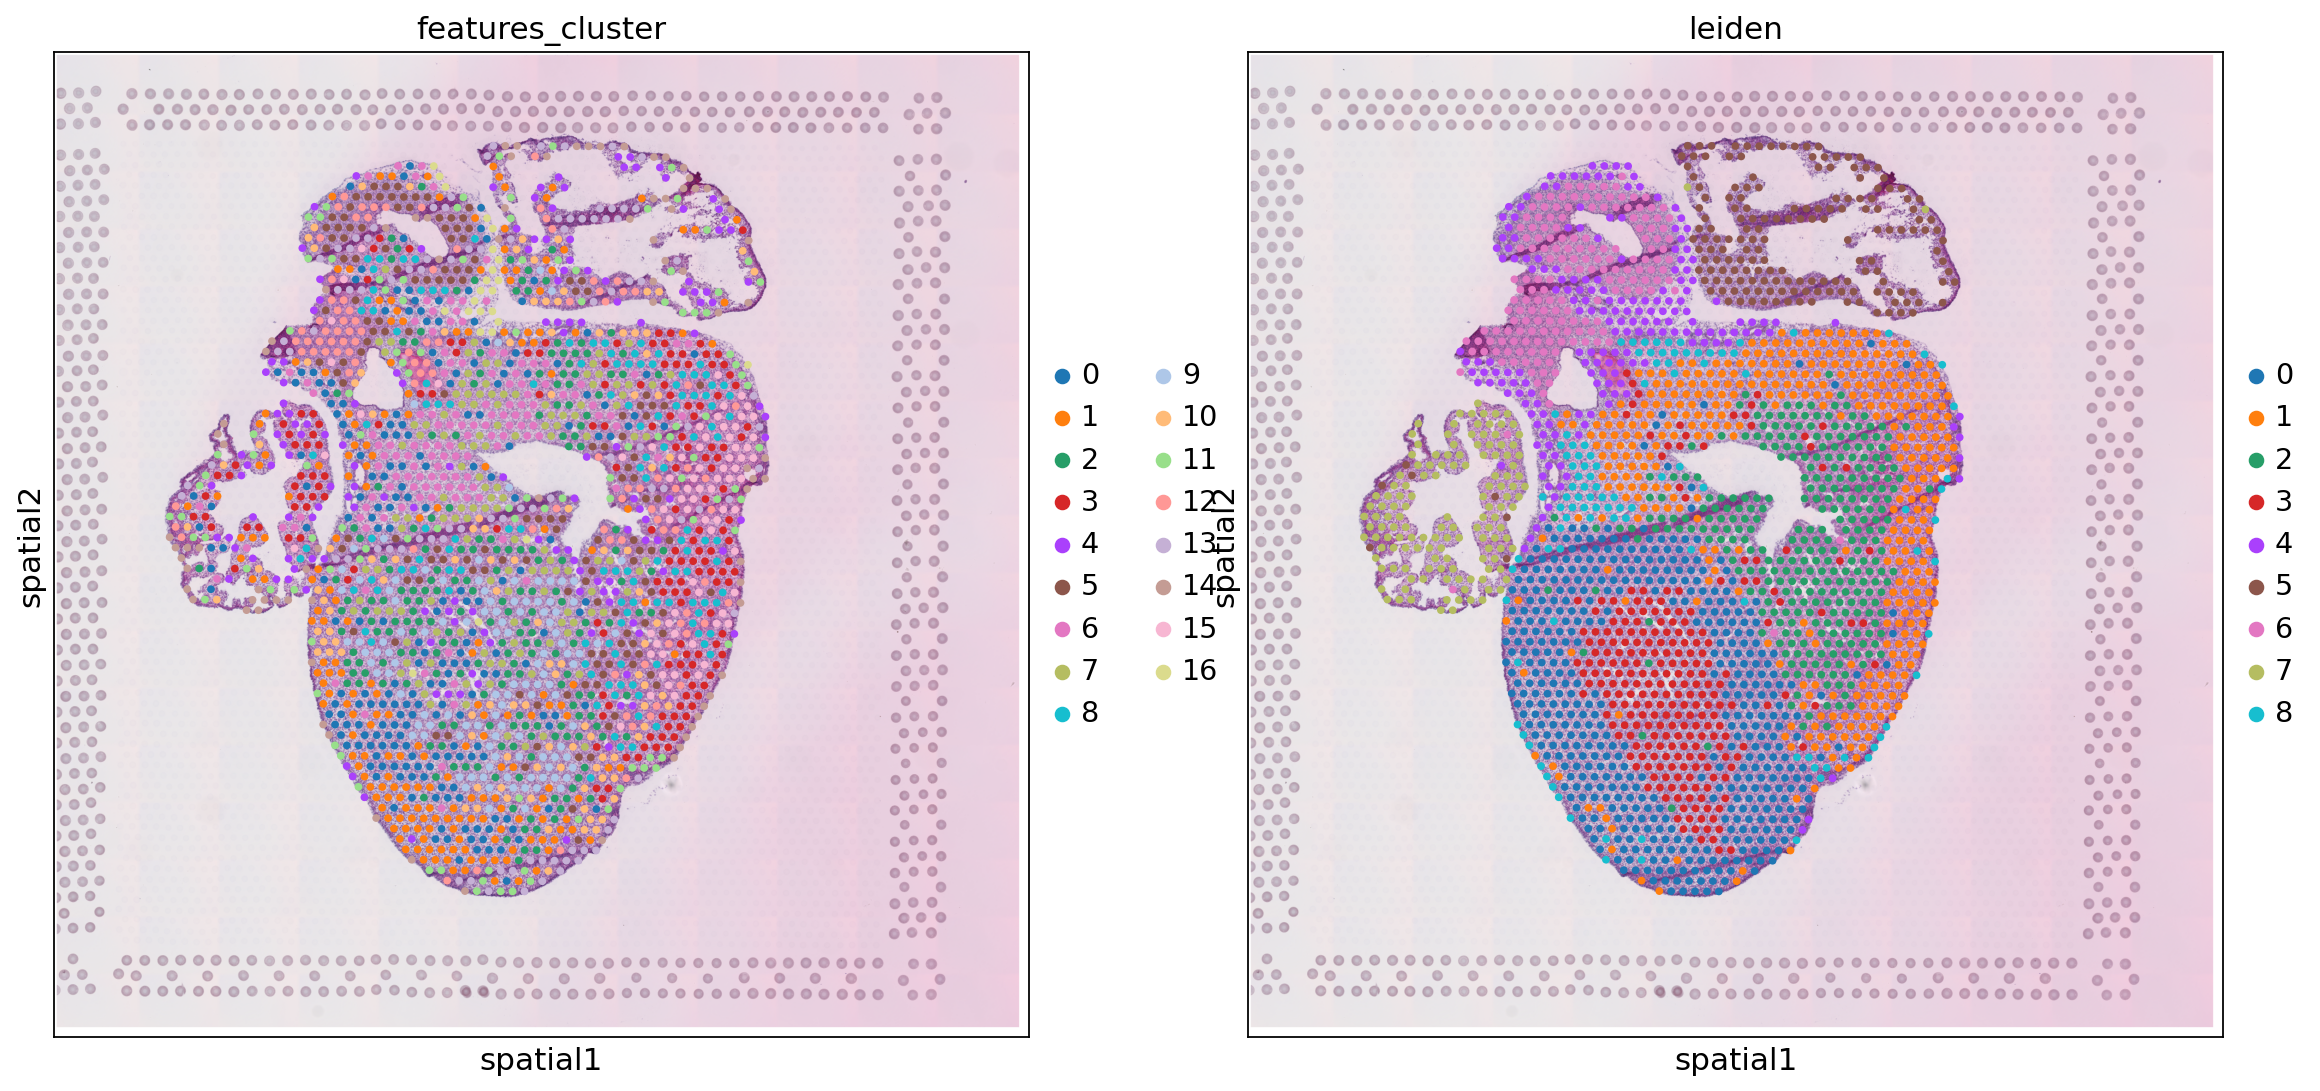

In [6]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"].values


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"])

# compare feature and gene clusters
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sq.pl.spatial_scatter(adata, color=["features_cluster", "leiden"])

This is only a simple, comparative analysis of the image features,
note that you could also use the image features to e.g. compute a common image and gene clustering
by computing a shared neighbors graph (for instance on concatenated PCAs on both feature spaces).

### Exercise
Compute a joint clustering on image and gexp features and plot it. How did the clustering change?
<details>
<summary>Hint</summary>
    
```python
adata_img = ad.AnnData(adata.obsm["features"])
sc.pp.neighbors(adata_img)
joint_adj = adata_img.obsp["connectivities"] + adata.obsp["connectivities"]
sc.tl.leiden(adata, adjacency=joint_adj, key_added="joint_leiden")
```
and plot with `sq.pl.spatial_scatter`
    
</details>

Then, do the same with the spatial graph. Tip: scale `spatial_connectivities` a bit (e.g. by 0.3).

Which tool does this analysis idea reminds you?

Spatial statistics and graph analysis
-------------------------------------
Similar to other spatial data, we can investigate spatial organization
by leveraging spatial and graph statistics in Visium data.

### Neighborhood enrichment

Computing a neighborhood enrichment can help us identify spots clusters that share
a common neighborhood structure across the tissue.
We can compute such score with the following function: :func:`squidpy.gr.nhood_enrichment`.
In short, it's an enrichment score on spatial proximity of clusters:
if spots belonging to two different clusters are often close to each other,
then they will have a high score and can be defined as being *enriched*.
On the other hand, if they are far apart, and therefore are seldom a neighborhood,
the score will be low and they can be defined as *depleted*. This score is
based on a permutation-based test, and you can set
the number of permutations with the ``n_perms`` argument (default is 1000).

In [7]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="leiden")

  0%|          | 0/1000 [00:00<?, ?/s]

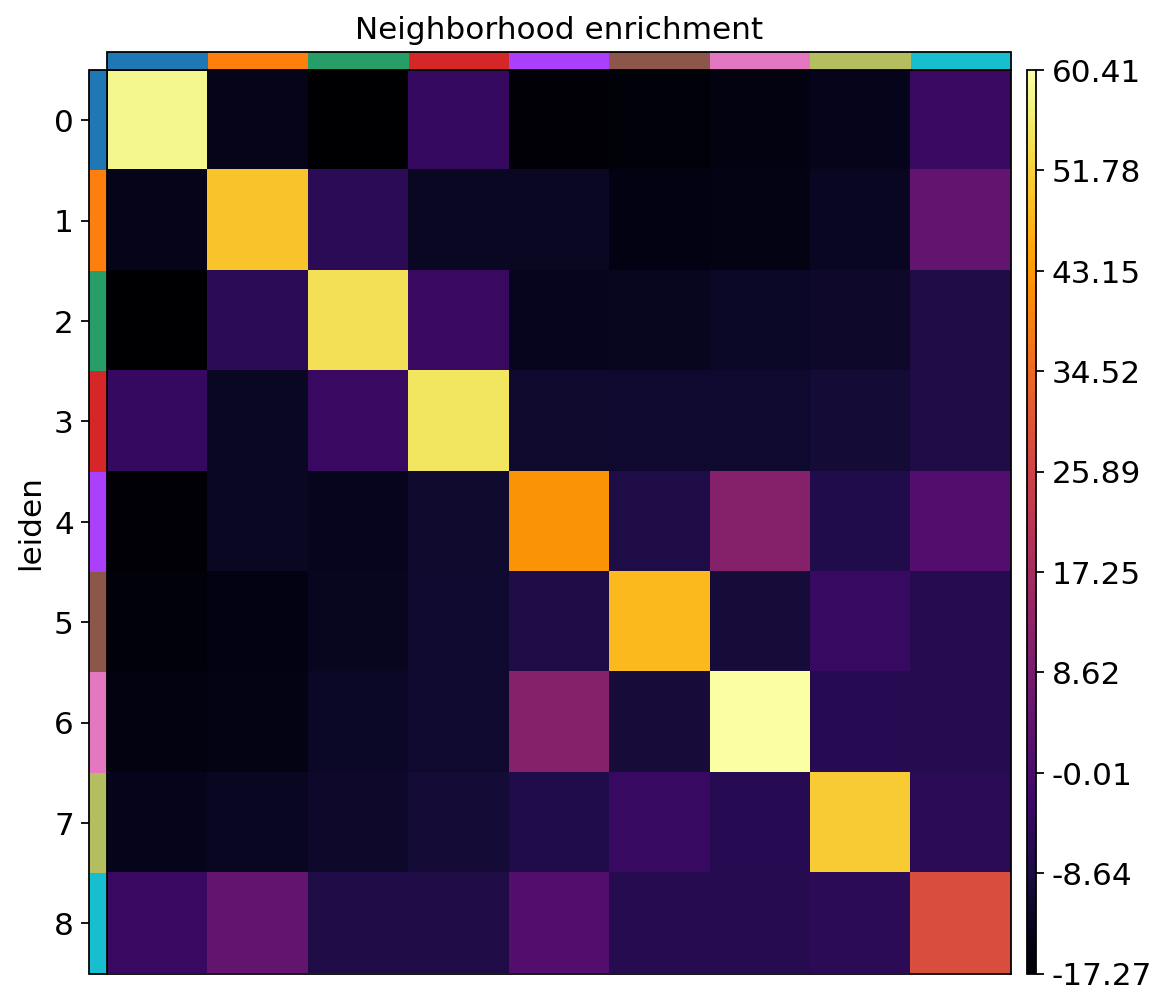

In [8]:
sq.pl.nhood_enrichment(adata, cluster_key="leiden", cmap="inferno")

## Co-occurrence across spatial dimensions

In addition to the neighbor enrichment score, we can visualize cluster
co-occurrence in spatial dimensions. This is a similar analysis of the
one presented above, yet it does not operate on the connectivity matrix,
but on the original spatial coordinates. The co-occurrence score is
defined as:

$$\frac{p(exp|cond)}{p(exp)}$$

where $p(exp|cond)$ is the conditional probability of observing a
cluster $exp$ conditioned on the presence of a cluster $cond$, whereas
$p(exp)$ is the probability of observing $exp$ in the radius size of
interest. The score is computed across increasing radii size around each
observation (i.e. spots here) in the tissue.

We are gonna compute such score with `squidpy.gr.co_occurrence` and set
the cluster annotation for the conditional probability with the argument
`leiden`. Then, we visualize the results with
`squidpy.pl.co_occurrence`.


  0%|          | 0/1 [00:00<?, ?/s]

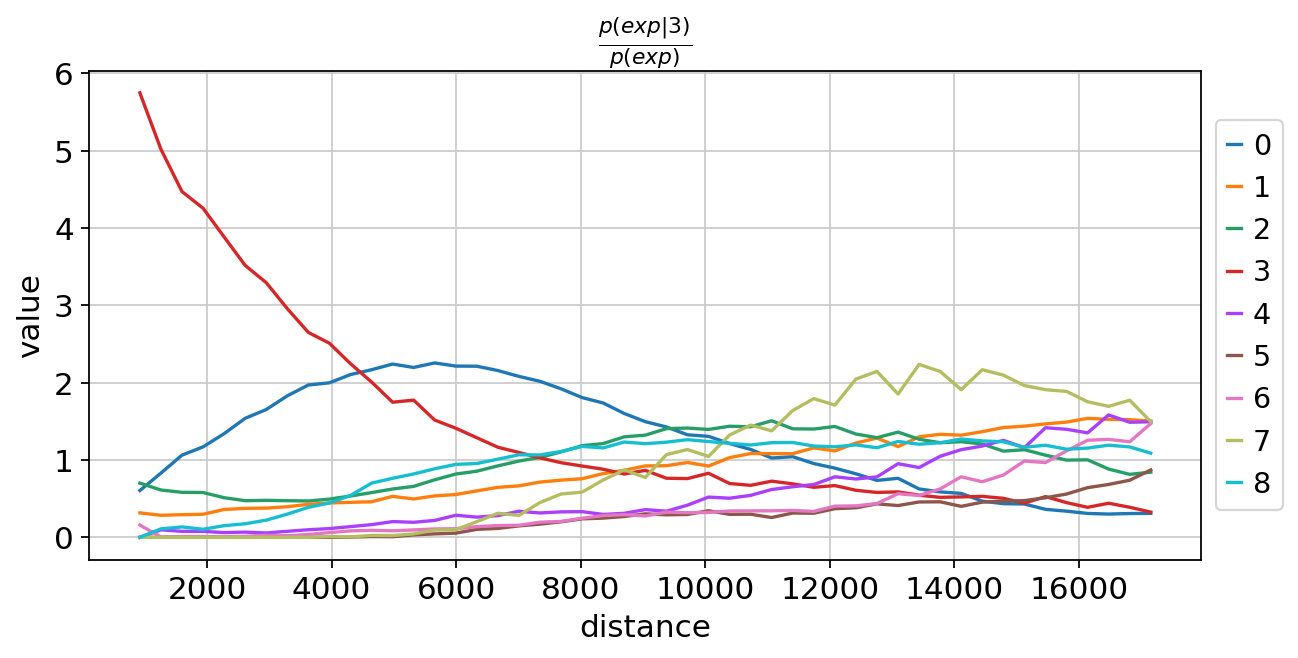

In [9]:
sq.gr.co_occurrence(adata, cluster_key="leiden")
sq.pl.co_occurrence(
    adata,
    cluster_key="leiden",
    clusters="3",
    figsize=(8, 4),
)

### Receptor interaction analysis

We are continuing the analysis showing couple of feature-level methods
that are very relevant for the analysis of spatial molecular data. For
instance, after quantification of cluster co-occurrence, we might be
interested in finding molecular instances that could potentially drive
cellular communication. This naturally translates in a receptor-ligand
interaction analysis. In Squidpy, we provide a fast re-implementation
the popular method CellPhoneDB `cellphonedb`
([code](https://github.com/Teichlab/cellphonedb) ) and extended its
database of annotated receptor-ligand interaction pairs with the popular
database *Omnipath* `omnipath`. You can run the analysis for all
clusters pairs, and all genes (in seconds, without leaving this
notebook), with `squidpy.gr.ligrec`. Furthermore, we\'ll directly
visualize the results, filtering out lowly-expressed genes (with the
`means_range` argument) and increasing the threshold for the adjusted
p-value (with the `alpha` argument).

In [10]:
sq.gr.ligrec(adata, n_perms=1000, cluster_key="leiden", use_raw=False)

  0%|          | 0/1000 [00:00<?, ?permutation/s]

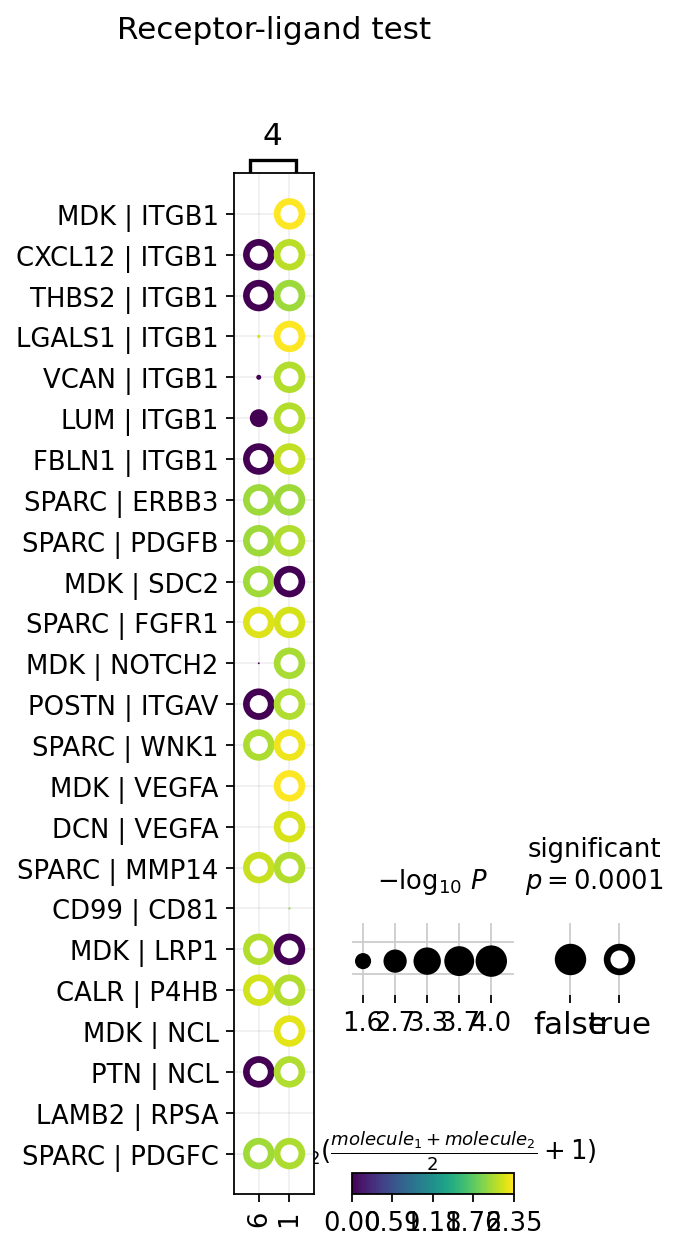

In [11]:
sq.pl.ligrec(
    adata,
    cluster_key="leiden",
    source_groups="4",
    target_groups=["6", "1"],
    means_range=(3, np.inf),
    alpha=1e-4,
)

The dotplot visualization provides an interesting set of candidate receptor-ligand
annotation that could be involved in cellular interactions.
A more refined analysis would be for instance to integrate these results with
the results of a deconvolution method, to understand what's the proportion of single-cell
cell types present in this region of the tissue.

### Exercise

Do a differential analysis with scanpy and check if any of the the ligand of source cluster 4 are also marker genes.

<details>
<summary>Hint</summary>
    
```python
sc.tl.rank_genes_groups(adata, groupby="leiden")
ranked_genes = sc.get.rank_genes_groups_df(adata, group="4", log2fc_min=2)
```
and plot with `sq.pl.spatial_scatter`.
    
</details>

Above, we looked at the neighborhood enrichment analysis, which calculates an enrichment value based on cluster proximity. On the other hand, the ligand receptor interaction analysis provide a different view on the putative cellular communication process, by measuring co-expression of receptor-ligand pairs. We can visualize such interaction score in a similar view as the neighborhood enrichment, by "counting" the number of significant interactions between clusters. 

Couple of things to consider:
- the result of the `ligrec` method is saved in `adata.uns["leiden_ligrec"]` with keys `means` and `pvalues`
- [numpy.masked_arrays](https://numpy.org/doc/stable/reference/maskedarray.generic.html) might be useful for this task.
- if you save the resulting "counting" matrix in `adata.uns["leiden_interactions"]` you can then visualize it with `sq.pl.interaction_matrix`

<details>
<summary>Hint</summary>
    
```python
clusters = adata.obs.leiden.cat.categories
pval = adata.uns["leiden_ligrec"]["pvalues"]
means = adata.uns["leiden_ligrec"]["means"]
interactions = np.ma.masked_where((pval < 1e-3) & (means > 1), means).mask.sum(0)

interactions = np.reshape(interactions, (clusters.shape[0], clusters.shape[0]))
adata.uns["leiden_interactions"] = interactions
sq.pl.interaction_matrix(adata, cluster_key="leiden", cmap="inferno")
```
    
</details>

# Spatially variable genes with Moran\'s I

Finally, we might be interested in finding genes that show spatial
patterns. There are several methods that aimed at address this
explicitly, based on point processes or Gaussian process regression
framework:

> -   *SPARK* -
>     [paper](https://www.nature.com/articles/s41592-019-0701-7#Abs1),
>     [code](https://github.com/xzhoulab/SPARK).
> -   *Spatial DE* -
>     [paper](https://www.nature.com/articles/nmeth.4636),
>     [code](https://github.com/Teichlab/SpatialDE).
> -   *trendsceek* -
>     [paper](https://www.nature.com/articles/nmeth.4634),
>     [code](https://github.com/edsgard/trendsceek).
> -   *HMRF* - [paper](https://www.nature.com/articles/nbt.4260),
>     [code](https://bitbucket.org/qzhudfci/smfishhmrf-py).

Here, we provide a simple approach based on the well-known [Moran\'s I
statistics](https://en.wikipedia.org/wiki/Moran%27s_I) which is in fact
used also as a baseline method in the spatially variable gene papers
listed above. The score is defined as:

$I=\frac{n}{W} \frac{\sum_{i=1}^{n} \sum_{j=1}^{n} w_{i, j} z_{i} z_{j}}{\sum_{i=1}^{n} z_{i}^{2}}$

where $z_{i}$ is the deviation of the feature from the mean $(x_{i}-\overline{X})$, $w_{i,j}$ is the spatial weight between observations, $n$ is the number of spatial units adn $W$ is the sum of all $w_{i,j}$.

The function in Squidpy is called
`squidpy.gr.spatial_autocorr`, and returns both test statistics and
adjusted p-values in `anndata.AnnData.var` slot. For time reasons, we
will evaluate a subset of the highly variable genes only.


In [12]:
rng = np.random.default_rng(42)
genes = rng.choice(
    adata[:, adata.var.highly_variable].var_names,
    100,
    replace=False,
)

sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    genes=genes,
    n_perms=100,
    n_jobs=2,
)

  0%|          | 0/100 [00:00<?, ?/s]

The results are saved in ``adata.uns['moranI']`` slot.
Genes have already been sorted by Moran's I statistic.

In [13]:
adata.uns["moranI"].head(10)

I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
FBLN5   0.602649        0.0  0.000178         0.0  0.009901  0.000279   
MDH1    0.589501        0.0  0.000178         0.0  0.009901  0.000339   
COX7C   0.523185        0.0  0.000178         0.0  0.009901  0.000242   
SH3BGR  0.405466        0.0  0.000178         0.0  0.009901  0.000210   
NREP    0.397020        0.0  0.000178         0.0  0.009901  0.000214   
MYOM2   0.380685        0.0  0.000178         0.0  0.009901  0.000209   
KCNA5   0.335548        0.0  0.000178         0.0  0.009901  0.000238   
HSPE1   0.324039        0.0  0.000178         0.0  0.009901  0.000231   
DBI     0.272112        0.0  0.000178         0.0  0.009901  0.000200   
PKP2    0.234077        0.0  0.000178         0.0  0.009901  0.000152   

        pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
FBLN5                0.0                0.0         0.016502  
MDH1                 0.0                0.0         0.016502  
COX7C                0.0                0.0         0.016502  
SH3BGR               0.0                0.0         0.016502  
NREP                 0.0                0.0         0.016502  
MYOM2                0.0                0.0         0.016502  
KCNA5                0.0                0.0         0.016502  
HSPE1                0.0                0.0         0.016502  
DBI                  0.0                0.0         0.016502  
PKP2                 0.0                0.0         0.016502

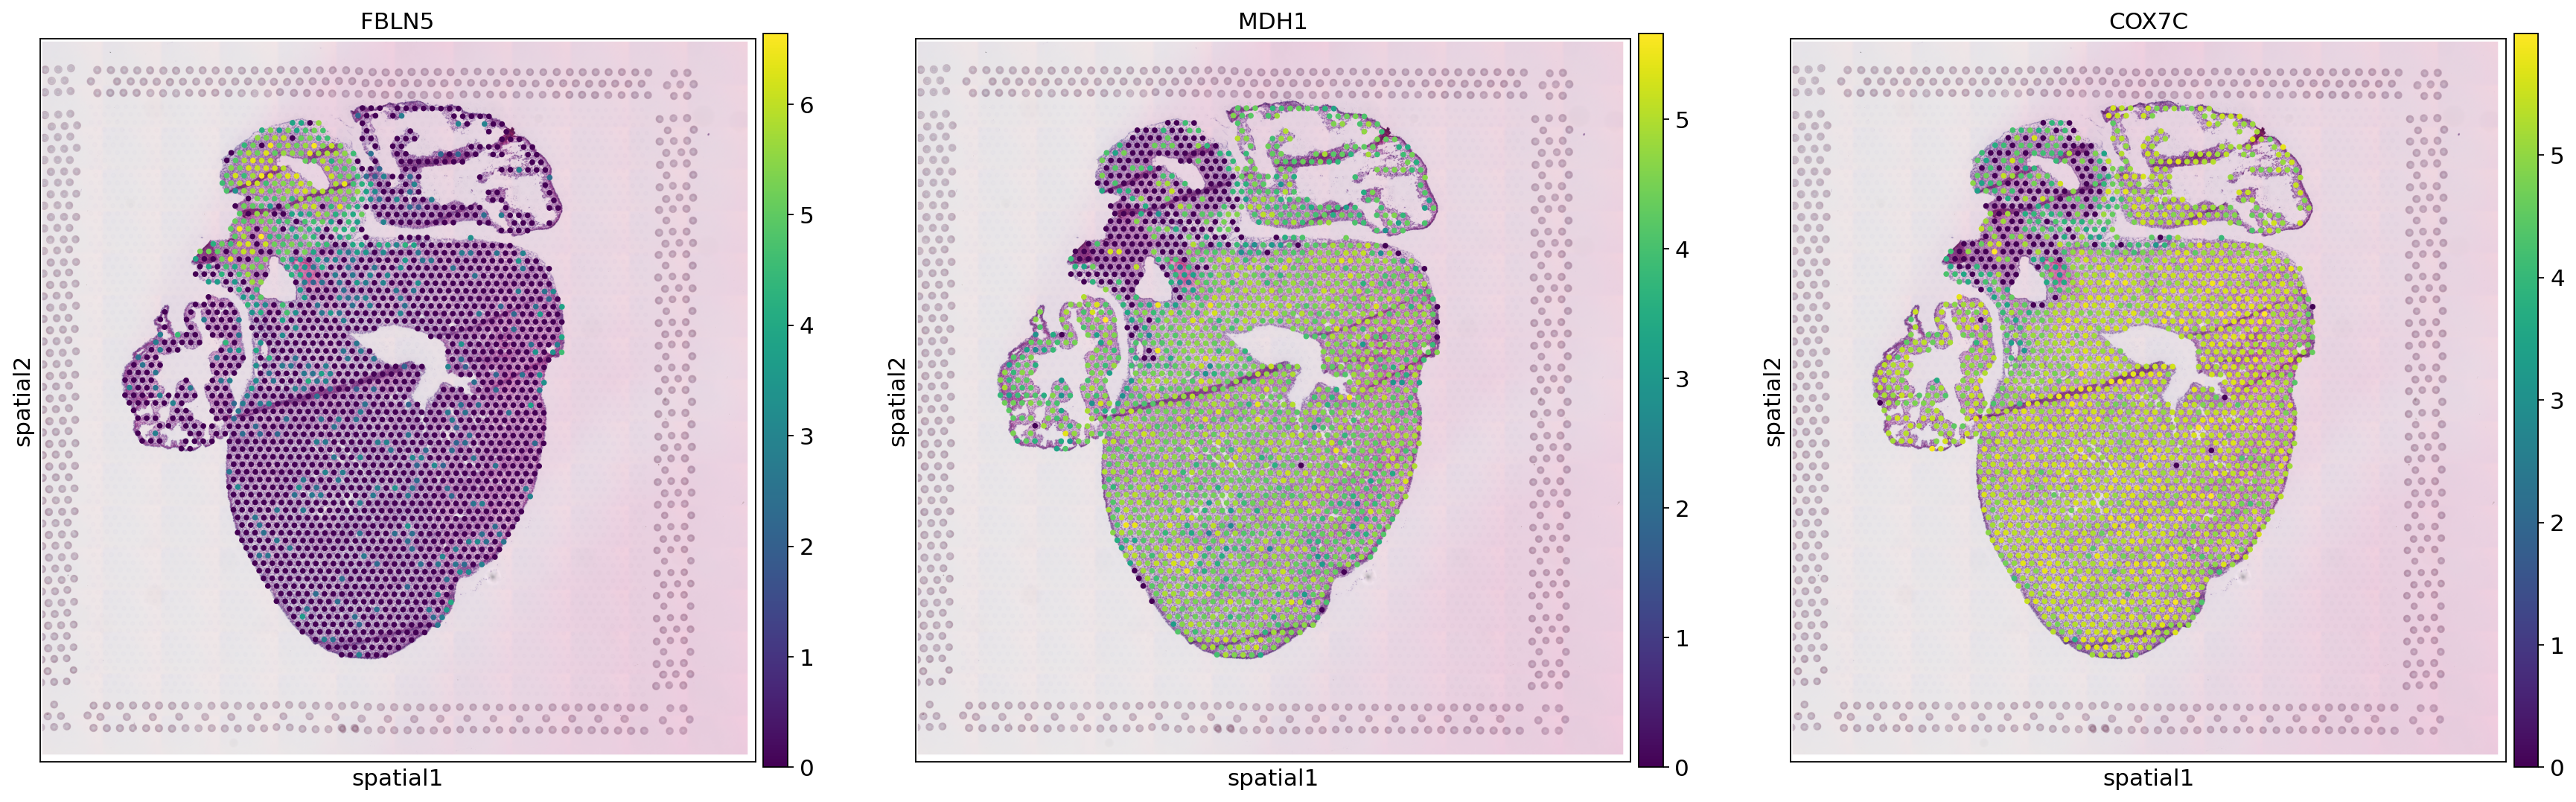

In [14]:
sq.pl.spatial_scatter(
    adata,
    color=[
        "FBLN5",
        "MDH1",
        "COX7C",
    ],
)